In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [134]:
df = pd.read_parquet('../data/btcusd_preprcd_2.parquet')
df.info()
df.describe()
df = df[150000:]

<class 'pandas.core.frame.DataFrame'>
Index: 442668 entries, 41 to 450017
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   close           442668 non-null  float64
 1   BB_up_diff      442668 non-null  float64
 2   BB_down_diff    442668 non-null  float64
 3   OBV             442668 non-null  float64
 4   MACD_Histogram  442668 non-null  float64
 5   RSI             442668 non-null  float64
 6   CCI             442668 non-null  float64
 7   predict_trend   442663 non-null  float64
dtypes: float64(8)
memory usage: 30.4 MB


In [135]:

# Assuming 'df' is your DataFrame with a 'price' column
df['log_return'] = np.log(df['close'] / df['close'].shift(-1))

# Create features
window = 48
df['momentum'] = df['log_return'].rolling(window).mean()
df['volatility'] = df['log_return'].rolling(window).std()

# Prepare features for clustering
features = ['momentum', 'volatility']
X = df[features].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
n_clusters = 2  # For high and low volatility regimes
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Assign regimes to the same index as X
df.loc[X.index, 'regime'] = kmeans.fit_predict(X_scaled)



# Print regime distribution
print(df['regime'].value_counts(normalize=True))

regime
1.0    0.879287
0.0    0.120713
Name: proportion, dtype: float64


In [136]:
def smooth_regimes(df, column, min_length):
    smoothed = df[column].copy()
    current_value = None
    count = 0

    for i in range(len(smoothed)):
        if smoothed.iloc[i] == current_value:
            count += 1
        else:
            if count < min_length and current_value is not None:
                smoothed.iloc[i-count:i] = current_value  # Use .iloc for positional indexing
            current_value = smoothed.iloc[i]
            count = 1

    # Handle the last sequence
    if count < min_length:
        smoothed.iloc[len(smoothed)-count:] = current_value  # Use .iloc for the last sequence

    return smoothed

# Example usage
df['smoothed_regimes'] = smooth_regimes(df, 'regime', min_length=3)
print(df['smoothed_regimes'].value_counts(normalize=True))

smoothed_regimes
1.0    0.879287
0.0    0.120713
Name: proportion, dtype: float64


In [137]:
df['regime'].describe()

count    292620.000000
mean          0.879287
std           0.325794
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: regime, dtype: float64

/var/folders/gn/mtbdxhjn1697bp_qhyd6y0cr0000gn/T/ipykernel_10595/637679655.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['smoothed_regimes'].fillna(df['smoothed_regimes'].mode()[0], inplace=True)


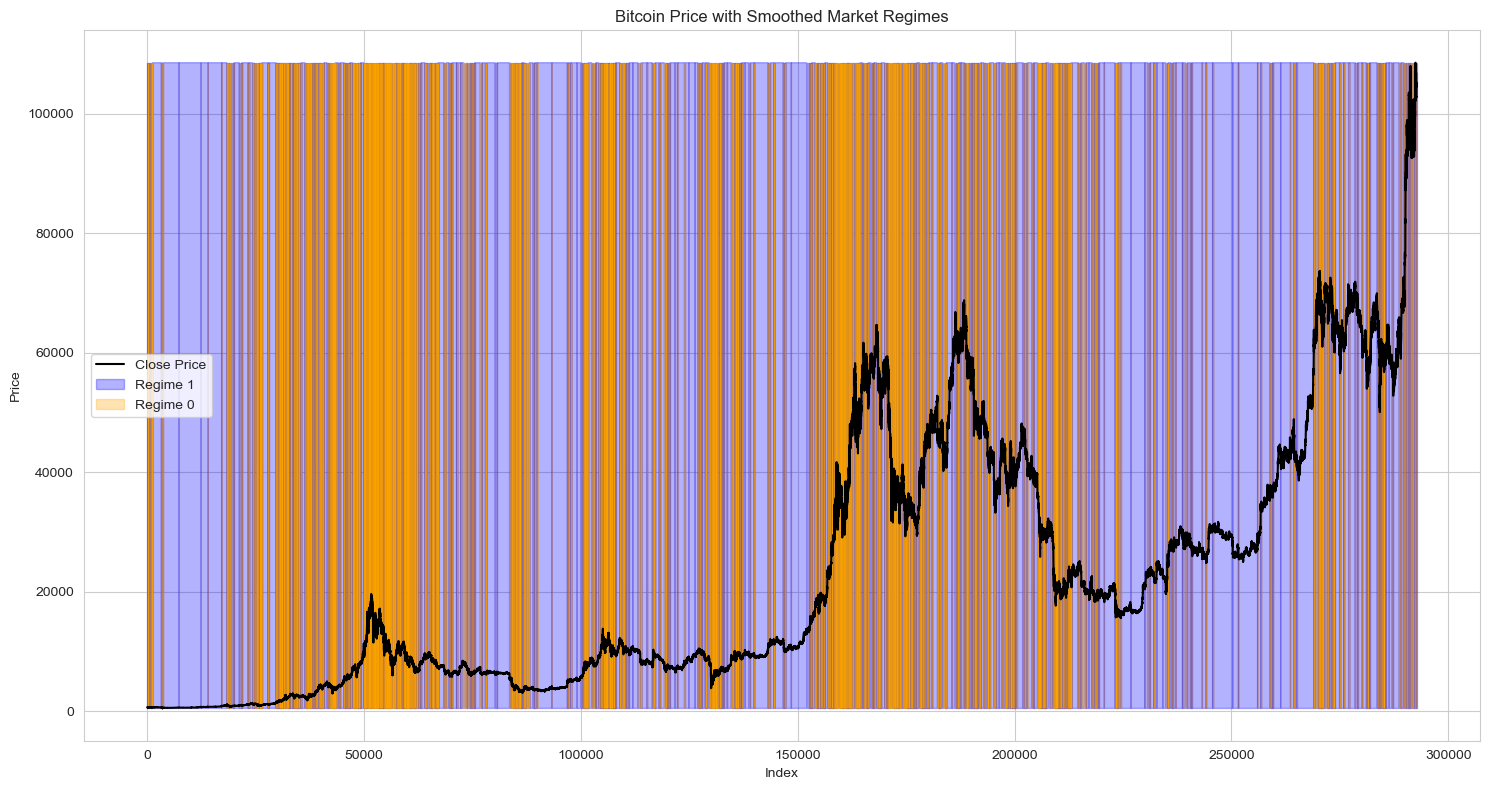

<Figure size 1500x800 with 0 Axes>

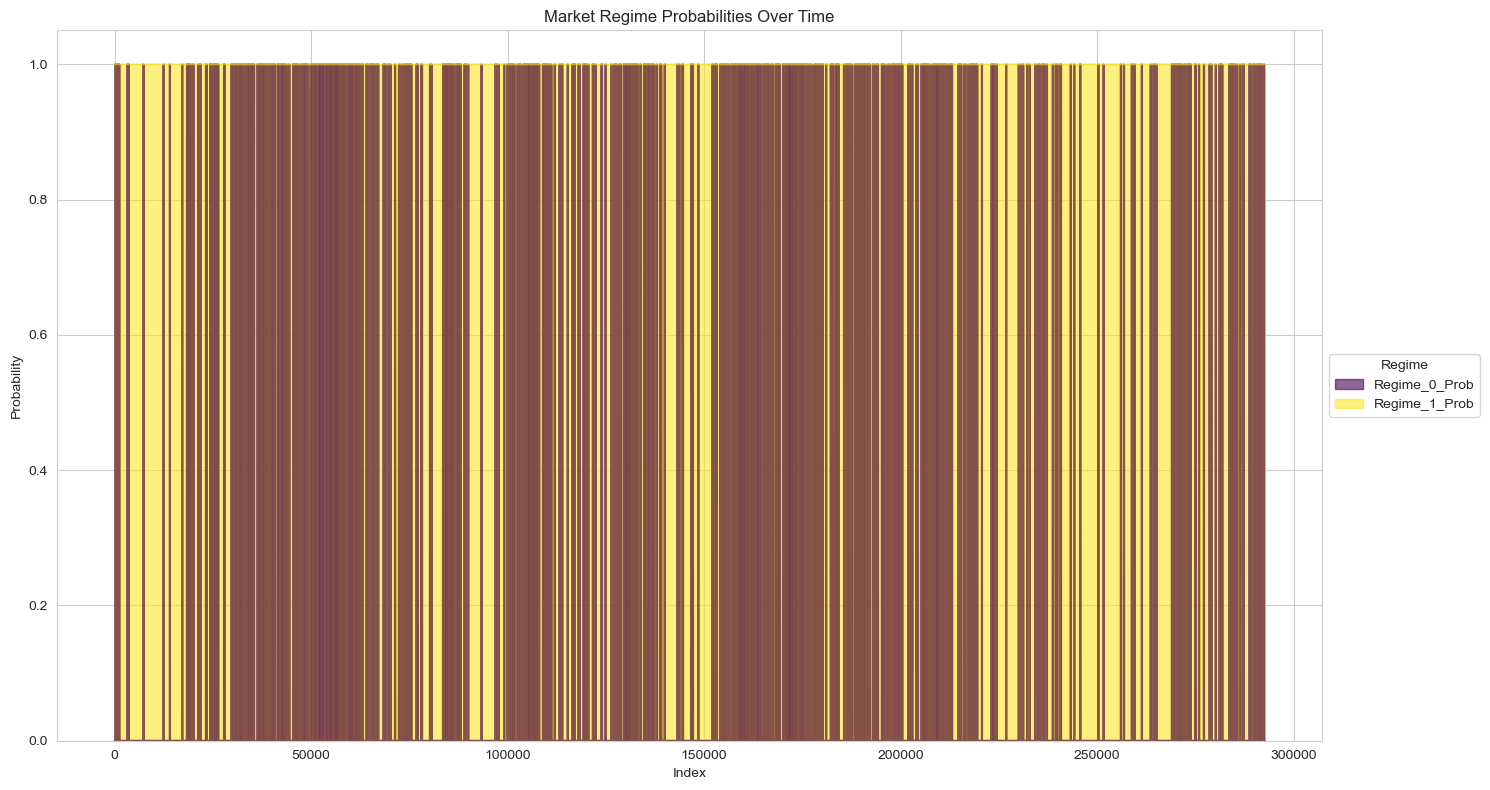

In [ ]:


# Line plot with regime shading
df['smoothed_regimes'].fillna(df['smoothed_regimes'].mode()[0], inplace=True)
df.reset_index(inplace=True)

# Line plot with regime shading
plt.figure(figsize=(15, 8))
sns.lineplot(data=df, x=df.index, y='close', color='black', label='Close Price')

# Shade background by regime
for regime in df['smoothed_regimes'].unique():
    mask = df['smoothed_regimes'] == regime
    plt.fill_between(
        df.index, 
        df['close'].min(), 
        df['close'].max(), 
        where=mask, 
        alpha=0.3, 
        label=f'Regime {int(regime)}', 
        color='blue' if regime == 1 else 'orange'
    )

plt.title('Bitcoin Price with Smoothed Market Regimes')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Improved Stacked Area Chart of Regime Probabilities
# Create probability columns for each regime
n_regimes = df['smoothed_regimes'].nunique()
for i in range(n_regimes):
    df[f'Regime_{i}_Prob'] = (df['smoothed_regimes'] == i).astype(int)

# Create the stacked area plot
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
sns.set_palette("husl", n_colors=n_regimes)

df[[f'Regime_{i}_Prob' for i in range(n_regimes)]].plot.area(stacked=True, alpha=0.6, figsize=(15, 8), cmap='viridis')

plt.title('Market Regime Probabilities Over Time')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend(title='Regime', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [139]:
df.drop(columns=['index', 'log_return',	'momentum',	'volatility', 'Regime_0_Prob',	'Regime_1_Prob'], inplace=True)
df.to_parquet('../data/btcusd_preprcd_with_regimes.parquet')

In [141]:
df['smoothed_regimes'].value_counts()

smoothed_regimes
1.0    257345
0.0     35323
Name: count, dtype: int64